# DESI Robot Keepout Polygons

Some documentation and tools related to the keepout polygons used to avoid collisions between fiber-positioning robots.

In [1]:
%matplotlib inline

In [14]:
from ast import literal_eval as safe_eval
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fpoffline.db
import fpoffline.io
import astropy.time
import fpoffline.scripts.endofnight

## Polygon Adjustment Parameters and Algorithms

The two arms of a fiber-positioning robot, labeled *theta* and *phi*, have a nominal keepout polygon that is then adjusted based on the following parameters from the calibration database:
 - KEEPOUT_EXPANSION_THETA_RADIAL in mm
 - KEEPOUT_EXPANSION_THETA_ANGULAR in deg
 - KEEPOUT_EXPANSION_PHI_RADIAL in mm
 - KEEPOUT_EXPANSION_PHI_ANGULAR in deg
 - LENGTH_R1 in mm
 - LENGTH_R2 in mm
 
The first 2 parameters adjust the theta polygon and the last 4 adjust the phi polygon.

The functions defined below use numpy, but the actual code used online uses Cython and lives in [poscollider.pyx](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/branches/kpnolinphi/petal/poscollider.pyx).

For an interactive demo of the adjustments try this [observable notebook](https://observablehq.com/@dkirkby/desi-keepouts).

Radial adjustments change the distance of each vertex from the origin by a fixed amount `dR` in mm:

In [3]:
def expanded_radially(poly, dR):
    x, y = np.array(poly)
    
    # This is the original implementation from PosPoly._expanded_radially
    #angle = np.arctan2(y, x)
    #x += dR * np.cos(angle)
    #y += dR * np.sin(angle)

    # This implementation is about 50% faster
    R = np.hypot(x, y)
    ratio = (R + dR) / R
    x *= ratio
    y *= ratio

    return x, y

Angular adjustments change the angle of each vertex relative to the origin by a fixed amount `dA` in degrees. Positive values move away from the positive x axis:

In [4]:
def expanded_angularly(poly, dA):
    dA = np.deg2rad(dA)
    x, y = poly
    
    # This is the original implementation from PosPoly._expanded_angularly
    angle = np.arctan2(y, x)
    angle += np.sign(angle) * dA
    R = np.hypot(x, y)
    xnew = R * np.cos(angle)
    ynew = R * np.sin(angle)

    # This alternate implementation runs at about the same speed
    #dA = dA * np.sign(y)
    #C = np.cos(dA)
    #S = np.sin(dA)
    #xnew = C * x - y * S
    #ynew = C * y + x * S
    
    return xnew, ynew

The radial and angular adjustments commute.

The phi keepout polygon is also adjusted based on any differences between the effective and nominal (3mm) arm lengths. These adjustments only affect x coordinates and use these two transformations:

In [5]:
def translated(poly, dx, dy):
    return poly + np.array((dx,dy)).reshape(2, 1)

In [6]:
def expanded_x(poly, left_shift, right_shift):
    x, y = np.array(poly)
    xpos = x > 0
    xneg = x < 0
    x[xpos] += right_shift
    x[xneg] -= left_shift
    return x, y

Putting the pieces together, the function below makes all of the adjustments to the nominal theta and phi keepout polygons:

In [7]:
def adjusted_keepouts(poly_T, poly_P, dR_T, dA_T, dR_P, dA_P, R1, R2, R1_nom=3, R2_nom=3):
    
    poly_T = expanded_radially(poly_T, dR_T)
    poly_T = expanded_angularly(poly_T, dA_T)

    poly_P = expanded_radially(poly_P, dR_P)
    poly_P = expanded_angularly(poly_P, dA_P)
    
    # true R1 err desired since it is kinematically real
    R1_error = R1 - R1_nom
    # only expand phi (not contract) it, since this is just distance to fiber,
    # and contraction might not represent true mechanical shape
    R2_error = max(R2 - R2_nom, 0)

    poly_P = translated(poly_P, dx=R1_error, dy=0)
    poly_P = expanded_x(poly_P, left_shift=R1_error, right_shift=R2_error)
    
    return poly_T, poly_P

## Load Adjustment Parameters from the Calibration Database

The code below will directly query the database when run at KPNO or its mirror at NERSC. Otherwise, it will fallback to the web-based interface to the mirror hosted at NERSC.

In [8]:
DB = fpoffline.db.DB()

In [9]:
calib = fpoffline.scripts.endofnight.get_calib(DB, at='2024-09-19 12:00:00 UTC')

Loaded 502 calib rows for petal_id 4
Loaded 502 calib rows for petal_id 5
Loaded 502 calib rows for petal_id 6
Loaded 502 calib rows for petal_id 3
Loaded 507 calib rows for petal_id 8
Loaded 506 calib rows for petal_id 10
Loaded 503 calib rows for petal_id 11
Loaded 510 calib rows for petal_id 2
Loaded 502 calib rows for petal_id 7
Loaded 502 calib rows for petal_id 9


Identify the unique combinations of the (radial,angular) expansion parameters for each arm:

In [11]:
def get_unique_keepouts():

    for arm in 'theta', 'phi':
        radial, angular = f'keepout_expansion_{arm}_radial', f'keepout_expansion_{arm}_angular'
        signatures = list(zip(np.round(calib[radial],3), np.round(calib[angular],3)))
        unique = set(signatures)
        print(f'Found {len(unique)} unique {arm} keepouts')
        for (rad,ang) in unique:
            mask = np.array([ sig == (rad,ang) for sig in signatures ])
            nmask = np.count_nonzero(mask)
            is_nonfunc = calib.device_classified_nonfunctional[mask]
            num_nonfunc = np.count_nonzero(is_nonfunc)
            print(f'  radial expansion = {rad} mm, angular expansion = {ang} deg: {nmask} robots ({num_nonfunc} non functional)')
            if nmask < 30:
                pos_ids = calib.pos_id[mask]
                print('   ',','.join(pos_ids))

get_unique_keepouts()

Found 4 unique theta keepouts
  radial expansion = 0.0 mm, angular expansion = 10.0 deg: 19 robots (15 non functional)
    M05797,M05970,M04980,M02668,M01133,M04386,M01956,M04712,M04722,M03545,M03945,M03503,M03979,M01758,M01491,M02258,M07715,M01759,M02254
  radial expansion = -0.5 mm, angular expansion = -7.0 deg: 26 robots (4 non functional)
    M03873,M05074,M05365,M02769,M03777,M04074,M05496,M03167,M04530,M05748,M05885,M03661,M03935,M03981,M03329,M05371,M07689,M01967,M07712,M01669,M01096,M01959,M04233,M07694,M03436,M02242
  radial expansion = 0.05 mm, angular expansion = 10.0 deg: 86 robots (84 non functional)
  radial expansion = 0.0 mm, angular expansion = 0.0 deg: 4907 robots (531 non functional)
Found 10 unique phi keepouts
  radial expansion = 0.0 mm, angular expansion = 10.0 deg: 38 robots (27 non functional)
  radial expansion = 0.2 mm, angular expansion = 20.0 deg: 1 robots (1 non functional)
    M03809
  radial expansion = 0.0 mm, angular expansion = 0.0 deg: 4864 robots (5

As of 2024-09-19, recovered linear-phi robots have an additional 5 deg of angular adjustment to the phi keepout, so we need to identify those.

In [10]:
linphis = calib[calib.zeno_motor_p == True].pos_id.tolist()
print(f'Found {len(linphis)} recovered linear phi robots')

Found 314 recovered linear phi robots


## Load Polygons Used by Fiber Assignment

Fiber assignment uses a daily snapshot of the focal plane state produced by the [PECS get_calibrations.py script](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/trunk/pecs/get_calibrations.py). Instead of calculating polygons from the calibration parameters, as done above, fiber assignment uses polygons stored in the snapshot that are computed by `plt.get_collider_polygons()` using online code in [poscollider.pyx](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/branches/kpnolinphi/petal/poscollider.pyx). These are the same polygons used online by the anti-collision scheduling code.

Read a snapshot (you will need to provide an appropriate path argument if not running at NERSC):

In [18]:
snapshot, snap_time = fpoffline.io.get_snapshot(timestamp=astropy.time.Time('2024-09-19T12:00:00', format='isot', scale='utc'))
print(f'Loading snapshot from {snap_time}')

Loading snapshot from 2024-09-18T17:01:16.000


Load and plot the nominal keepouts from the snapshot:

In [19]:
canonical = lambda k: np.round(safe_eval(k), 5)

In [20]:
nominal_T = canonical(snapshot.meta["general_keepout_T"])
nominal_P = canonical(snapshot.meta["general_keepout_P"])

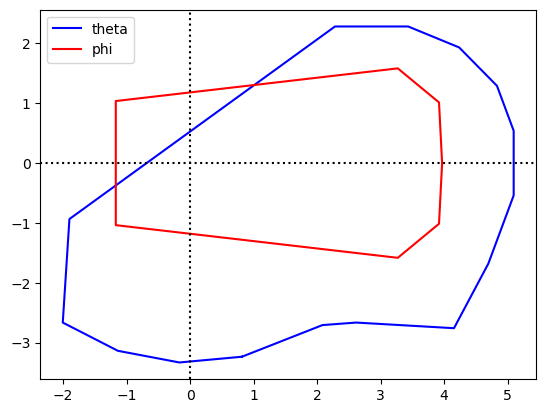

In [24]:
plt.plot(*nominal_T, 'b-', label='theta')
plt.plot(*nominal_P, 'r-', label='phi')
plt.axvline(0, c='k', ls=':')
plt.axhline(0, c='k', ls=':')
plt.legend()
plt.savefig('nominals.jpg');

Plot all of the adjusted keepout polygons stored in the snapshot:

In [38]:
def plot_keepouts(snap, arm, save=None):
    
    nominal = nominal_T if arm =='T' else nominal_P
    color = 'b' if arm == 'T' else 'r'
    
    # Loop over robots
    for row in snap:
        # Load the saved polygon
        poly = canonical(row[f"KEEPOUT_{arm}"])
        plt.plot(*poly, '-', c=color, alpha=0.1, lw=0.5)

    # Overplot the nominal keepout in black
    plt.plot(*nominal, 'k-', lw=1)
        
    plt.axvline(0, c='k', ls=':')
    plt.axhline(0, c='k', ls=':')
    if save:
        plt.savefig(save)

There are only 4 different theta keepouts, as expected from the unique combinations of the radial and angular expansion parameters listed above:

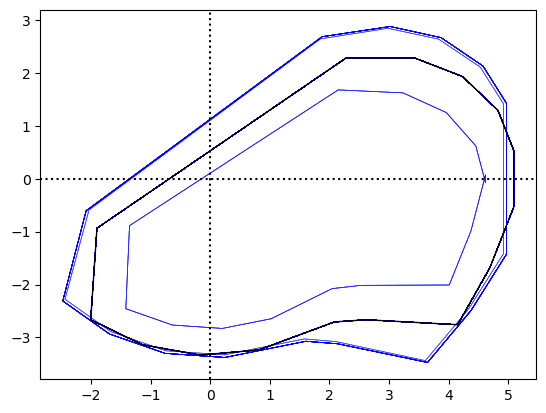

In [36]:
plot_keepouts(snapshot, 'T', save='theta_keepouts.jpg')

There are many different phi keepouts since these reflect the effective arm lengths of each robot:

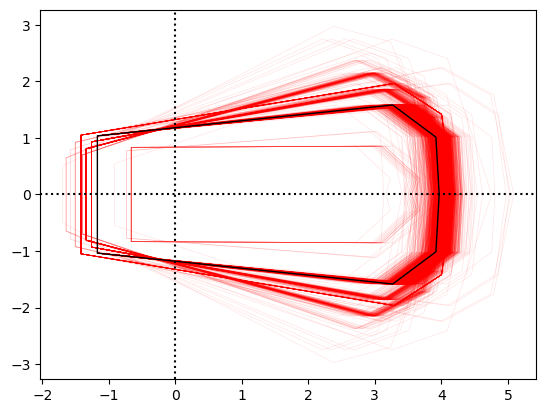

In [37]:
plot_keepouts(snapshot, 'P', save='phi_keepouts.jpg')

## Verify Computed Polygons

Verify that we can reproduce the saved polygons used by fiber assignment starting from the values of the 6 calibration parameters listed above.

In [50]:
def verify_keepouts(snap, arm, linphi_dA=5, R1_nom=3, R2_nom=3):
    
    nominal = nominal_T if arm =='THETA' else nominal_P
    bad_matches = [ ]
    
    # Loop over robots
    for row in snap:
        
        pos_id = row['POS_ID']
        
        # Load the saved polygon
        saved = canonical(row[f"KEEPOUT_{arm[0]}"])
        
        # Load the adjustment params saved in the snapshot (originally from the calib DB)
        dR = row[f"KEEPOUT_EXPANSION_{arm}_RADIAL"]
        dA = row[f"KEEPOUT_EXPANSION_{arm}_ANGULAR"]
        
        # Adjust the nominal polygon using these parameters
        computed = expanded_radially(nominal, dR)
        computed = expanded_angularly(computed, dA)
        
        # Perform an extra angular adjustment for linear phis
        if arm == 'PHI' and pos_id in linphis:
            computed = expanded_angularly(computed, linphi_dA)
        
        # Perform additional adjustments based on the arm lengths for PHI only
        if arm == 'PHI':
            R1 = row["LENGTH_R1"]
            R2 = row["LENGTH_R2"]
            # true R1 err desired since it is kinematically real
            R1_error = R1 - R1_nom
            # only expand phi (not contract) it, since this is just distance to fiber,
            # and contraction might not represent true mechanical shape
            R2_error = max(R2 - R2_nom, 0)
            # Apply adjustments in x only based on R1,R2 errors
            computed = translated(computed, dx=R1_error, dy=0)
            computed = expanded_x(computed, left_shift=R1_error, right_shift=R2_error)
            
        # Check that the saved and computed polygons match.
        # We the computed vertices to 5 decimal places since the saved vertices have the same rounding applied.
        if not np.allclose(saved, np.round(computed, 5)):
            bad_matches.append(pos_id)

    if any(bad_matches):
        print(f'Polygons do not match for {len(bad_matches)} robots')
    else:
        print(f'All polygons match')

In [48]:
verify_keepouts(snapshot, 'THETA')

All polygons match


In [49]:
verify_keepouts(snapshot, 'PHI')

All polygons match
